In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='W', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
# cluster.scale(20)
# # # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/mars4/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43078 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:43300 Dashboard: http://127.0.0.1:43078/status,Cluster Workers: 8 Cores: 56 Memory: 270.19 GB


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
# import numpy_groupies
import dask.array as dsar
import xrft
import qgutils
from xgcm.grid import Grid
import os.path as op
# from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib as mpl
mpl.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [3]:
ddir = '/store/CT1/hmg2840/tuchida/msqg/seas-forcing/'
rund = '/store/tuchida/msom/msqg/'

In [4]:
U = .1
T = 5e5    # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4   # Rossby radius (50km)
Re4 = 4e3
# f0 = 8e-5
beta = .5
N = 1024   # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
ntime = int(62.2*5)+1

percent = 20
nmemb = 100

In [5]:
ds = xr.open_zarr(op.join(rund, 'ctrl/vars001'))

Frm = xr.DataArray(np.array([0.00409959,0.01319355]), dims='Zp1', 
                   coords={'Zp1':ds.Zp1}
                  )
aFrN = xr.DataArray(np.array([0.1,0.]), dims='Zp1', 
                    coords={'Zp1':ds.Zp1}
                   )
fFr_r = 62.2
Fr = np.sqrt(1. + np.sin(2*np.pi*fFr_r**-1*ds.time)*aFrN)**-1 * Frm
gp = Fr**-2 * ds.drC

In [6]:
dtt = 7
for tt in range(int(312/dtt)+1):
    if tt < 44:
        if tt == 0:
            dsE = xr.open_zarr(op.join(rund,"Energy001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        else:
            dsE = xr.concat([dsE,xr.open_zarr(op.join(rund,"Energy001/%03d-%03d" 
                                                      % (tt*dtt,tt*dtt+dtt-1)))
                            ], 'time')
    else:
        dsE = xr.concat([dsE,xr.open_zarr(op.join(rund,"Energy001/%03d-%03d" 
                                                  % (308,311)))
                        ], 'time')

In [7]:
dtt = 7
for tt in range(int(312/dtt)+1):
    if tt < 44:
        if tt == 0:
            dsP = xr.open_zarr(op.join(rund,"Pis001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        else:
            dsP = xr.concat([dsP,xr.open_zarr(op.join(rund,"Pis001/%03d-%03d" 
                                                      % (tt*dtt,tt*dtt+dtt-1)))
                            ], 'time')
    else:
        dsP = xr.concat([dsP,xr.open_zarr(op.join(rund,"Pis001/%03d-%03d" 
                                                  % (308,311)))
                        ], 'time')

In [8]:
dtt = 7
for tt in range(int(312/dtt)+1):
    if tt < 44:
        if tt == 0:
            dsv = xr.open_zarr(op.join(rund,"vKE001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        else:
            dsv = xr.concat([dsv,xr.open_zarr(op.join(rund,"vKE001/%03d-%03d" 
                                                      % (tt*dtt,tt*dtt+dtt-1)))
                            ], 'time')
    else:
        dsv = xr.concat([dsv,xr.open_zarr(op.join(rund,"vKE001/%03d-%03d" 
                                                  % (308,311)))
                        ], 'time')

In [9]:
dtt = 7
for tt in range(int(312/dtt)+1):
    if tt < 44:
        if tt == 0:
            dsD = xr.open_zarr(op.join(rund,"HDiss001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        else:
            dsD = xr.concat([dsD,xr.open_zarr(op.join(rund,"HDiss001/%03d-%03d" 
                                                      % (tt*dtt,tt*dtt+dtt-1)))
                            ], 'time')
    else:
        dsD = xr.concat([dsD,xr.open_zarr(op.join(rund,"HDiss001/%03d-%03d" 
                                                  % (308,311)))
                        ], 'time')
visEAPE = dsD.DhEAPE
visMAPE = dsD.DhMAPE
visEKE = dsD.DhEKE
visMKE = dsD.DhMKE

In [13]:
p_k_1 = dsP.p_k.isel(Zp1=0).sum(['YC','XC']).compute() * dx**2
p_k_2 = dsP.p_k.isel(Zp1=1).sum(['YC','XC']).compute() * dx**2
P_K_1 = dsP.P_K.isel(Zp1=0).sum(['YC','XC']).compute() * dx**2
P_K_2 = dsP.P_K.isel(Zp1=1).sum(['YC','XC']).compute() * dx**2

K1_k1 = (dsP.K_k.isel(Z=0).sum(['YC','XC']).compute() 
        ) * dx**2
K2_k2 = (dsP.K_k.isel(Z=1).sum(['YC','XC']).compute()
        ) * dx**2
K3_k3 = (dsP.K_k.isel(Z=2).sum(['YC','XC']).compute()
        ) * dx**2

K1_K2 = dsv.K1_K2.sum(['YC','XC']).compute() * dx**2
k1_k2 = dsv.k1_k2.sum(['YC','XC']).compute() * dx**2
K2_K3 = dsv.K2_K3.sum(['YC','XC']).compute() * dx**2
k2_k3 = dsv.k2_k3.sum(['YC','XC']).compute() * dx**2

MKE = dsE.MKE
EKE = dsE.EKE
MAPE = dsE.MAPE
EAPE = dsE.EAPE

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

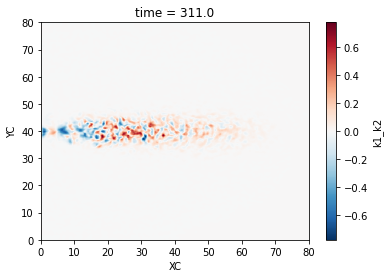

In [44]:
dsv.k1_k2.isel(time=0).plot()

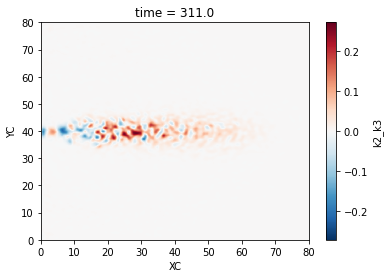

In [45]:
dsv.k2_k3.isel(time=0).plot()

In [12]:
P1_p1 = (dsP.P_p.isel(Zp1=0).sum(['YC','XC']).compute() 
        ) * dx**2
P2_p2 = (dsP.P_p.isel(Zp1=1).sum(['YC','XC']).compute()
        ) * dx**2

In [13]:
visMKEh = (visMKE * ds.drF).sum(['YC','XC']).compute() * dx**2
visMAPEh = visMAPE.sum(['YC','XC']).compute() * dx**2
visEKEh = (visEKE * ds.drF).sum(['YC','XC']).compute() * dx**2
visEAPEh = visEAPE.sum(['YC','XC']).compute() * dx**2

In [16]:
EKEh = (EKE*ds.drF).sum(['YC','XC']).compute() * dx**2
HEKE = (EKE*ds.drF).sum(['YC','XC']).sum('Z').compute() * dx**2 

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


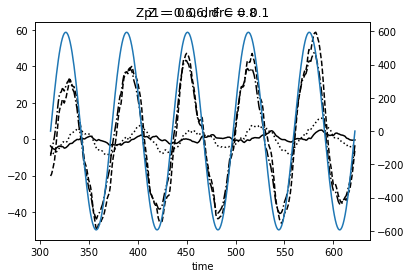

In [38]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
# ax3 = ax.twinx()
(HEKE-HEKE.mean()).plot(ax=ax,c='k',ls='--')
(EKEh.isel(Z=0)-EKEh.isel(Z=0).mean()).plot(ax=ax,c='k',ls='-.')
(EKEh.isel(Z=1)-EKEh.isel(Z=1).mean()).plot(ax=ax,c='k')
(EKEh.isel(Z=-1)-EKEh.isel(Z=-1).mean()).plot(ax=ax,c='k',ls=':')
(gp.isel(Zp1=0)-gp.isel(Zp1=0).mean()).plot(ax=ax2)

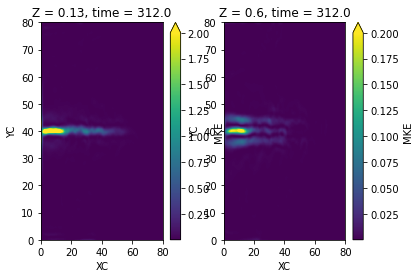

In [42]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
MKE.isel(time=1,Z=1).plot(ax=ax1,vmax=2)
MKE.isel(time=1,Z=2).plot(ax=ax2,vmax=.2)

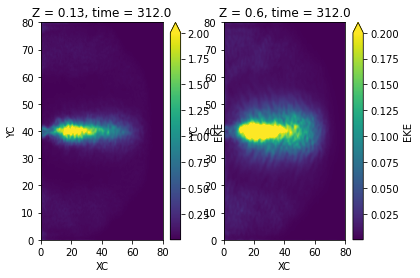

In [43]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
EKE.isel(time=1,Z=1).plot(ax=ax1,vmax=2)
EKE.isel(time=1,Z=2).plot(ax=ax2,vmax=.2)

distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


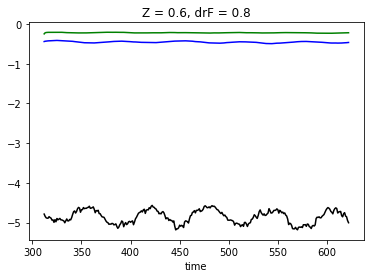

In [29]:
fig, ax = plt.subplots()
visEKEh.isel(time=slice(1,None),Z=0).plot(ax=ax,c='k')
(visEKEh).isel(time=slice(1,None),Z=1).plot(ax=ax,c='b')
(visEKEh).isel(time=slice(1,None),Z=2).plot(ax=ax,c='g')

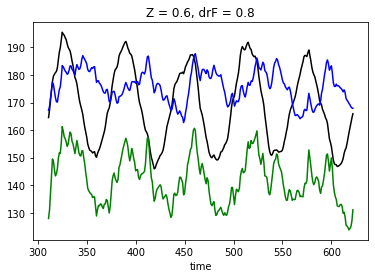

In [21]:
MKEh = (MKE*ds.drF).sum(['YC','XC']).compute() * dx**2 

fig, ax = plt.subplots()
MKEh.isel(Z=0).plot(ax=ax,c='k')
(MKEh*6).isel(Z=1).plot(ax=ax,c='b')
(MKEh*9).isel(Z=2).plot(ax=ax,c='g')

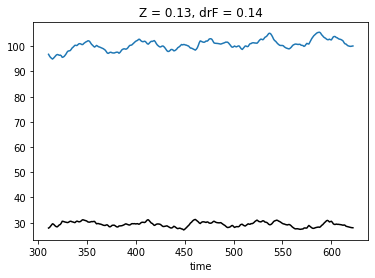

In [22]:
fig, ax = plt.subplots()
MKEh.isel(Z=1).plot(ax=ax,c='k')
EKEh.isel(Z=1).plot(ax=ax)

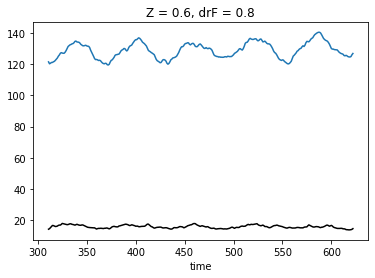

In [23]:
fig, ax = plt.subplots()
MKEh.isel(Z=-1).plot(ax=ax,c='k')
EKEh.isel(Z=-1).plot(ax=ax)

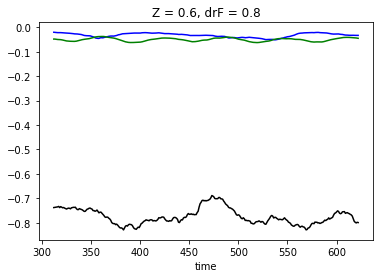

In [30]:
fig, ax = plt.subplots()
visMKEh.isel(time=slice(1,None),Z=0).plot(ax=ax,c='k')
(visMKEh).isel(time=slice(1,None),Z=1).plot(ax=ax,c='b')
(visMKEh).isel(time=slice(1,None),Z=2).plot(ax=ax,c='g')

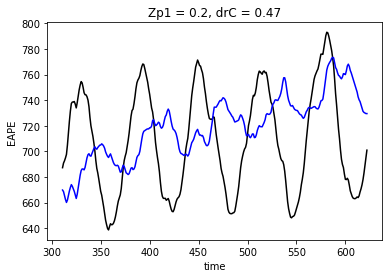

In [14]:
EAPEh = EAPE.sum(['YC','XC']).compute() * dx**2 

fig, ax = plt.subplots()
EAPEh.isel(Zp1=0).plot(ax=ax,c='k')
(EAPEh*3).isel(Zp1=1).plot(ax=ax,c='b')

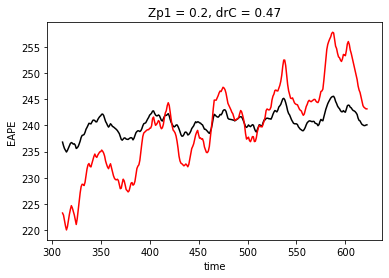

In [43]:
fig, ax = plt.subplots()
(EKEh+140).isel(Z=1).plot(ax=ax,c='k')
EAPEh.isel(Zp1=1).plot(ax=ax,c='r')

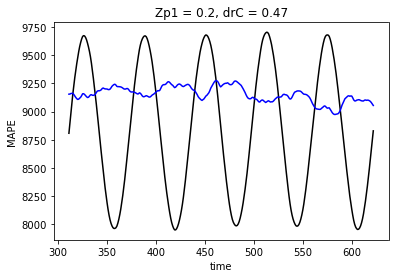

In [15]:
MAPEh = MAPE.sum(['YC','XC']).compute() * dx**2 

fig, ax = plt.subplots()
MAPEh.isel(Zp1=0).plot(ax=ax,c='k')
(MAPEh*10).isel(Zp1=1).plot(ax=ax,c='b')

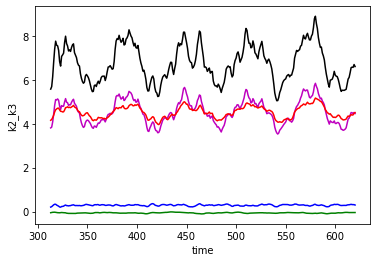

In [14]:
fig, ax = plt.subplots()
(K1_k1* U**2*H/T*Rd**2*1e-6).rolling(time=5, center=True).mean().plot(ax=ax,c='k')
(K2_k2* U**2*H/T*Rd**2*1e-6).rolling(time=5, center=True).mean().plot(ax=ax,c='b')
(K3_k3* U**2*H/T*Rd**2*1e-6).rolling(time=5, center=True).mean().plot(ax=ax,c='g')
(k1_k2* U**2*H/T*Rd**2*1e-6).rolling(time=5, center=True).mean().plot(ax=ax,c='m')
(k2_k3* U**2*H/T*Rd**2*1e-6).rolling(time=5, center=True).mean().plot(ax=ax,c='r')

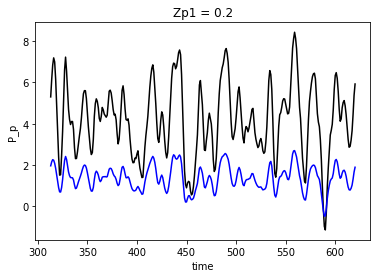

In [39]:
fig, ax = plt.subplots()
P1_p1.rolling(time=5, center=True).mean().plot(ax=ax,c='k')
P2_p2.rolling(time=5, center=True).mean().plot(ax=ax,c='b')

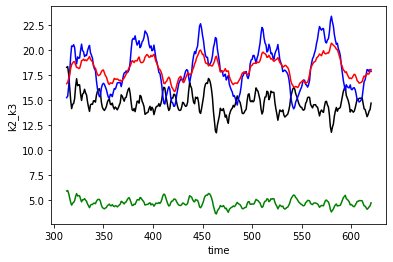

In [15]:
fig, ax = plt.subplots()
K1_K2.rolling(time=5, center=True).mean().plot(ax=ax,c='k')
k1_k2.rolling(time=5, center=True).mean().plot(ax=ax,c='b')
K2_K3.rolling(time=5, center=True).mean().plot(ax=ax,c='g')
k2_k3.rolling(time=5, center=True).mean().plot(ax=ax,c='r')

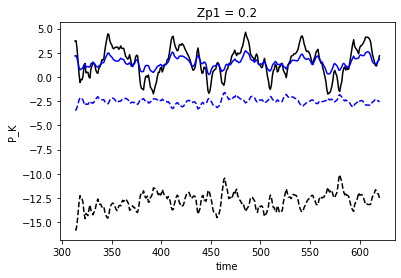

In [46]:
fig, ax = plt.subplots()
p_k_1.rolling(time=5, center=True).mean().plot(ax=ax,c='k')
p_k_2.rolling(time=5, center=True).mean().plot(ax=ax,c='b')
P_K_1.rolling(time=5, center=True).mean().plot(ax=ax,c='k',ls='--')
P_K_2.rolling(time=5, center=True).mean().plot(ax=ax,c='b',ls='--')

In [17]:
print((np.argmax(np.correlate((EKEh.isel(Z=0)-EKEh.isel(Z=0).mean()), 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean()), mode='full'
                             )) - (ntime - 1.)
      ) * T/86400.)
print((np.argmax(np.correlate((EKEh.isel(Z=1)-EKEh.isel(Z=1).mean()), 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean()), mode='full'
                             )) - (ntime - 1.)
      ) * T/86400. + 360)
print((np.argmax(np.correlate((EKEh.isel(Z=2)-EKEh.isel(Z=2).mean()), 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean()), mode='full'
                             )) - (ntime - 1.)
      ) * T/86400.)

5.787037037037037
128.5185185185185
63.657407407407405


In [28]:
print((np.argmax(np.correlate((visEKEh.isel(time=slice(1,None),Z=0)-visEKEh.isel(time=slice(1,None),Z=0).mean()), 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean()), mode='full'
                             )) - (ntime - 1.)
      ) * T/86400.)
print((np.argmax(np.correlate((visEKEh.isel(time=slice(1,None),Z=1)-visEKEh.isel(time=slice(1,None),Z=1).mean()), 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean()), mode='full'
                             )) - (ntime - 1.)
      ) * T/86400.)
print((np.argmax(np.correlate((visEKEh.isel(time=slice(1,None),Z=2)-visEKEh.isel(time=slice(1,None),Z=2).mean()), 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean()), mode='full'
                             )) - (ntime - 1.)
      ) * T/86400.)

167.82407407407408
5.787037037037037
-40.50925925925926


In [22]:
print((np.argmax(np.correlate((MKEh.isel(Z=0)-MKEh.isel(Z=0).mean()), 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean()), mode='full'
                             )) - (ntime - 1.)
      ) * T/86400.)
print((np.argmax(np.correlate((MKEh.isel(Z=1)-MKEh.isel(Z=1).mean()), 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean()), mode='full'
                             )) - (ntime - 1.)
      ) * T/86400.)
print((np.argmax(np.correlate((MKEh.isel(Z=2)-MKEh.isel(Z=2).mean()), 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean()), mode='full'
                             )) - (ntime - 1.)
      ) * T/86400.)

5.787037037037037
121.52777777777777
52.083333333333336


In [18]:
print((np.argmax(np.correlate((EAPEh.isel(Zp1=0)-EAPEh.isel(Zp1=0).mean()), 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean()), mode='full'
                             ))- (ntime - 1.)
      ) * T/86400.)
print((np.argmax(np.correlate((EAPEh.isel(Zp1=1)-EAPEh.isel(Zp1=1).mean()), 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean()), mode='full'
                             ))- (ntime - 1.)
      ) * T/86400. + 360)

11.574074074074074
128.5185185185185


In [19]:
print((np.argmax(np.correlate((k1_k2-k1_k2.mean()).rolling(time=5, center=True).mean()[2:-2], 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean())[2:-2], mode='full'
                             )) - (ntime - 1. - 4.)
      ) * T/86400.)
print((np.argmax(np.correlate((k2_k3-k2_k3.mean()).rolling(time=5, center=True).mean()[2:-2], 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean())[2:-2], mode='full'
                             )) - (ntime - 1. - 4.)
      ) * T/86400.)

0.0
11.574074074074074


In [20]:
p_k = dsP.p_k.sum(['Zp1','YC','XC']).compute() * dx**2
print((np.argmax(np.correlate((p_k-p_k.mean()).rolling(time=5, center=True).mean()[2:-2], 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean())[2:-2], mode='full'
                             )) - (ntime - 1. - 4.)
      ) * T/86400.)

distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


173.61111111111111


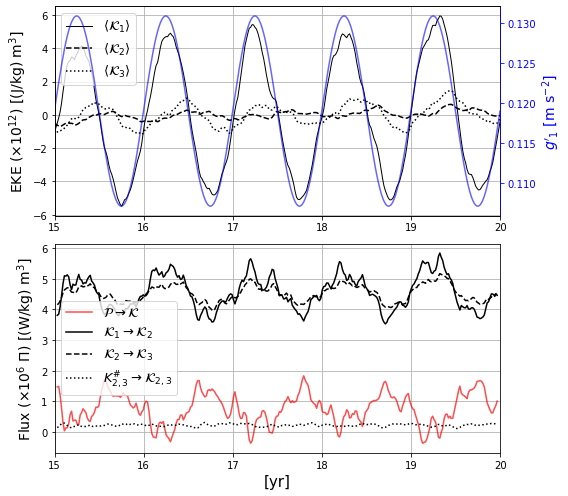

In [19]:
fig, (ax1,ax3) = plt.subplots(figsize=(8,7), nrows=2, ncols=1)
fig.set_tight_layout(True)
ax2 = ax1.twinx()
# ax4 = ax3.twinx()


# ax1.plot(ds.time*T/(diny*86400)+1e1, K1_K2, 'k', lw=2,
#         label=r"$K^\#_1\rightarrow K^\#_2$")
# ax1.plot((ds.time+ds.time[-1])*T/(diny*86400), 
#          k1_k2 * U**2*H/T*Rd**2*1e-6, 'k--', lw=1,
#          label=r"$\mathcal{K}_1\rightarrow \mathcal{K}_2$"
#         )
# ax1.plot((ds.time+ds.time[-1])*T/(diny*86400), 
#          k1_k2.rolling(time=5, center=True).mean() * U**2*H/T*Rd**2*1e-6, 'k', 
#          label=r"$\mathcal{K}_1\rightarrow \mathcal{K}_2$")
# ax1.plot(ds.time*T/(diny*86400)+1e1, K2_K3, 'r', lw=2, alpha=.8,
#         label=r"$K^\#_2\rightarrow K^\#_3$")

ax1.plot((ds.time+ds.time[-1])*T/(diny*86400), 
         (EKEh.isel(Z=0)-EKEh.isel(Z=0).mean()) * U**2*H*Rd**2 * 1e-12, 'k', lw=1,
         label=r"$\langle \mathcal{K}_1 \rangle$"
        )
ax1.plot((ds.time+ds.time[-1])*T/(diny*86400), 
         (EKEh.isel(Z=1)-EKEh.isel(Z=1).mean()) * U**2*H*Rd**2 * 1e-12, 'k', ls='--',
         label=r"$\langle \mathcal{K}_2 \rangle$"
        )
ax1.plot((ds.time+ds.time[-1])*T/(diny*86400), 
         (EKEh.isel(Z=2)-EKEh.isel(Z=2).mean()) * U**2*H*Rd**2 * 1e-12, 'k', ls=':',
         label=r"$\langle \mathcal{K}_3 \rangle$"
        )

ax3.plot((ds.time+ds.time[-1])*T/(diny*86400), 
         (dsP.p_k.sum(['Zp1','YC','XC']).compute().rolling(time=5, center=True).mean() 
          * dx**2 * U**2*H/T*Rd**2 * 1e-6), 'r', alpha=.7,
         label=r"$\mathcal{P} \rightarrow \mathcal{K}$"
        )
ax3.plot((ds.time+ds.time[-1])*T/(diny*86400), 
         (k1_k2.compute().rolling(time=5, center=True).mean() 
          * U**2*H/T*Rd**2 * 1e-6), 'k',
         label=r"$\mathcal{K}_1 \rightarrow \mathcal{K}_2$"
        )
ax3.plot((ds.time+ds.time[-1])*T/(diny*86400), 
         (k2_k3.compute().rolling(time=5, center=True).mean() 
          * U**2*H/T*Rd**2 * 1e-6), 'k', ls='--',
         label=r"$\mathcal{K}_2 \rightarrow \mathcal{K}_3$"
        )

ax3.plot((ds.time+ds.time[-1])*T/(diny*86400), 
         ((K2_k2+K3_k3).rolling(time=5, center=True).mean() 
          * U**2*H/T*Rd**2 * 1e-6), 'k', ls=':',
         label=r"$K^\#_{2,3} \rightarrow \mathcal{K}_{2,3}$"
        )
# ax2.plot((ds.time+ds.time[-1])*T/(diny*86400), 
#          (dsP.p_k.isel(Zp1=1).sum(['YC','XC']).compute().rolling(time=5, center=True).mean() 
#           * dx**2 * U**2*H/T*Rd**2), 'r', ls=':',
#          label=r"$\mathcal{P}_2 \rightarrow \mathcal{K}$"
#         )

# ax1.plot((ds.time+ds.time[-1])*T/(diny*86400), 
#          k2_k3 * U**2*H/T*Rd**2*1e-6, 'r--', lw=1,
#          label=r"$\mathcal{K}_2\rightarrow \mathcal{K}_3$"
#         )
# ax1.plot((ds.time+ds.time[-1])*T/(diny*86400), 
#          k2_k3.rolling(time=5, center=True).mean() * U**2*H/T*Rd**2*1e-6, 'r', 
#          label=r"$\mathcal{K}_2\rightarrow \mathcal{K}_3$")

# ax1.plot((ds.time+ds.time[-1])*T/(diny*86400), 
#          p1_k2 * U**2*H/T*Rd**2*1e-6, 'r--', lw=1,
#          label=r"$\mathcal{K}_2\rightarrow \mathcal{K}_3$"
#         )
# ax1.plot((ds.time+ds.time[-1])*T/(diny*86400), 
#          p1_k2.rolling(time=5, center=True).mean() * U**2*H/T*Rd**2*1e-6, 'r', 
#          label=r"$\mathcal{P}_1\rightarrow \mathcal{K}_2$")

# ax1.plot((ds.time+ds.time[-1])*T/(diny*86400), 
#          p2_k3 * U**2*H/T*Rd**2*1e-6, 'g--', lw=1,
#          label=r"$\mathcal{K}_2\rightarrow \mathcal{K}_3$"
#         )
# ax1.plot((ds.time+ds.time[-1])*T/(diny*86400), 
#          p2_k3.rolling(time=5, center=True).mean() * U**2*H/T*Rd**2*1e-6, 'g', 
#          label=r"$\mathcal{P}_2\rightarrow \mathcal{K}_3$")

# ax1.plot((ds.time+ds.time[-1])*T/(diny*86400), 
#          p1_k1 * U**2*H/T*Rd**2*1e-6, 'c--', lw=1,
#          label=r"$\mathcal{K}_2\rightarrow \mathcal{K}_3$"
#         )
# ax1.plot((ds.time+ds.time[-1])*T/(diny*86400), 
#          p1_k1.rolling(time=5, center=True).mean() * U**2*H/T*Rd**2*1e-6, 'c', 
#          label=r"$\mathcal{P}_1\rightarrow \mathcal{K}_1$")


ax2.plot((ds.time+ds.time[-1])*T/(diny*86400), 
         gp.isel(Zp1=0) * U**2/(ds.drC.isel(Zp1=0)*H), 'b', alpha=.6)
# ax4.plot((ds.time+ds.time[-1]-1)*T/(diny*86400), gp.isel(Zp1=0), 'b', alpha=.7)

ax1.set_xlim([15.,20.])
ax3.set_xlim([15.,20.])
# ax1.set_ylim([100.,900.])
ax1.legend(fontsize=13, loc='upper left')
ax3.legend(fontsize=13, loc='center left')
ax1.grid(True)
ax3.grid(True)
ax3.set_xlabel(r"[yr]", fontsize=15)
ax1.set_ylabel(r"EKE ($\times 10^{12}$) [(J/kg) m$^3$]", fontsize=14)
ax3.set_ylabel(r"Flux ($\times 10^{6}\ \Pi$) [(W/kg) m$^3$]", fontsize=14)
ax2.set_ylabel(r"$g'_1$ [m s$^{-2}$]", fontsize=14, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')

# ax3.set_xlim([15.,20.])
# ax3.set_ylim([-3.,3.])
# ax3.legend(fontsize=13, loc='lower left')
# ax3.grid(True)
# ax3.set_ylabel(r"Energy flux ($\Pi$)", fontsize=15)
# ax4.set_ylabel(r"$g'_1$", fontsize=14, c='b')
# ax4.spines['right'].set_color('b')
# ax4.tick_params(axis='y', colors='b')

plt.savefig(op.join(rund,'Figs/eddyPis_interlayer.pdf'))